In [61]:
import gc
from tqdm.notebook import tqdm
import random

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# import keras
# from keras.models import Model, Sequential
from keras.utils.vis_utils import model_to_dot
# from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Input, GaussianNoise
import tensorflow as tf
# from keras import regularizers, backend as K

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers, backend as K

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

import mlflow.keras
import mlflow
mlflow.keras.autolog()


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) # NumPy
random.seed(RANDOM_SEED) # Python
tf.set_random_seed(RANDOM_SEED) # Tensorflow

LABELS = ["Normal", "Fraud"]

## 1. Data loading

In [62]:
folder_path = '../data/'

indenti = pd.read_csv(f'{folder_path}train_transaction.csv')

train = pd.read_csv(f'{folder_path}train_transaction.csv')

## 2. Data exploration 

### Transaction

features:
* TransactionID - unique id 
* isFraud - value to predict
* TransactionDT - timedelta from a given reference datetime (not an actual timestamp)
* TransactionAmt - amount in USD
* dist1,dist2 - distance
* C1 ... C14 - counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked
* D1 ... D15 - timedelta, such as days between previous transaction
* V1 ... V339 - vesta engineered rich features

categorical_features: 
* ProductCD - product code 
* P_emaildomain,R_emaildomain - purchaser and recipient email domain
* card1 ... card6 - payment card information
* addr1,addr2 - address(region, country)
* M1 ... M9 - match, such as names on card and address

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-671062


In [63]:
# features
base_features = ['TransactionID', 'isFraud', 'TransactionDT']

c_counting_features = ['C' + str(n) for n in range(1,15)]
d_timedelta_features = ['D' + str(n) for n in range(1,16)]
numerical_features = ['TransactionAmt', 'dist1', 'dist2'] + c_counting_features + d_timedelta_features 

vesta_features = ['V' + str(n) for n in range(1,340)]

# categorical_features
m_features = ['M' + str(n) for n in range(1,10)]
card_features = ['card' + str(n) for n in range(1,7)]
categorical_features = ['ProductCD','P_emaildomain','R_emaildomain', 'addr1','addr2'] + m_features + card_features

# all features
all_features = base_features + numerical_features + vesta_features + categorical_features

# train = train[base_features + categorical_features + numerical_features]

In [64]:
frauds = train[train.isFraud == 1]
normal = train[train.isFraud == 0]
print('Shape: ', train.shape)
print("Number of fraud txs: ", len(frauds))
print("Number of normal txs: ", len(normal))
print("Procentage of fraud txs: ", len(frauds)/len(train)*100)

Shape:  (590540, 394)
Number of fraud txs:  20663
Number of normal txs:  569877
Procentage of fraud txs:  3.4990009144173126


In [65]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Non Categorical features

In [66]:
train[numerical_features].isnull().sum(axis = 0)

TransactionAmt         0
dist1             352271
dist2             552913
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823
D13               528588
D14               528353
D15                89113
dtype: int64

### Categorical features

In [67]:
for col in categorical_features:
    print("Unique values for ", col, len(train[col].unique()))
    
train[categorical_features].isnull().sum(axis = 0)

Unique values for  ProductCD 5
Unique values for  P_emaildomain 60
Unique values for  R_emaildomain 61
Unique values for  addr1 333
Unique values for  addr2 75
Unique values for  M1 3
Unique values for  M2 3
Unique values for  M3 3
Unique values for  M4 4
Unique values for  M5 3
Unique values for  M6 3
Unique values for  M7 3
Unique values for  M8 3
Unique values for  M9 3
Unique values for  card1 13553
Unique values for  card2 501
Unique values for  card3 115
Unique values for  card4 5
Unique values for  card5 120
Unique values for  card6 5


ProductCD             0
P_emaildomain     94456
R_emaildomain    453249
addr1             65706
addr2             65706
M1               271100
M2               271100
M3               271100
M4               281444
M5               350482
M6               169360
M7               346265
M8               346252
M9               346252
card1                 0
card2              8933
card3              1565
card4              1577
card5              4259
card6              1571
dtype: int64

## 3. Data preparation

https://www.kaggle.com/abazdyrev/keras-nn-focal-loss-experiments

In [68]:
X = train.sort_values('TransactionDT').drop(['isFraud'], axis=1)
y = train.sort_values('TransactionDT')['isFraud'].to_numpy()
del train

In [69]:
from utils.tranformers import drop_columns, CategoricalTransformer, NumericalTransformer


def get_categories(df, n_values = 50):
    categories = []
    
    for column in df.columns:
        categories.append(list(df[column].value_counts().iloc[: n_values - 1].index) + ['other'])
        
    return categories

categories = get_categories(X[categorical_features])

categorical_pipe = make_pipeline(
    CategoricalTransformer(categories), 
    OneHotEncoder(categories = categories, sparse = False )
)

numerical_pipe = make_pipeline(
    NumericalTransformer(), 
    StandardScaler(), 
    SimpleImputer(strategy='constant', fill_value=0, missing_values=np.nan)
)

transformer = make_column_transformer(
    (FunctionTransformer(drop_columns), ['TransactionDT', 'TransactionID'] + vesta_features),
    (categorical_pipe, categorical_features),
    (numerical_pipe, numerical_features),
)

X = transformer.fit_transform(X)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## 4. Model building

Based on https://arxiv.org/pdf/1908.11553.pdf

In [71]:
EPOCHS = 10

def make_model():
    model = keras.Sequential()
    
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(500, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(250, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(.1))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=['acc']
    )
    return model

model = make_model()

history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_test, y_test), 
    epochs=EPOCHS,
    shuffle=True,
    batch_size=128).history


Train on 472432 samples, validate on 118108 samples
Epoch 1/10
472432/472432 [==============================] - 28s 60us/sample - loss: 0.0990 - acc: 0.9726 - val_loss: 0.0928 - val_acc: 0.9736
Epoch 2/10
472432/472432 [==============================] - 33s 69us/sample - loss: 0.0896 - acc: 0.9747 - val_loss: 0.0880 - val_acc: 0.9747
Epoch 3/10
472432/472432 [==============================] - 35s 73us/sample - loss: 0.0840 - acc: 0.9761 - val_loss: 0.0849 - val_acc: 0.9764
Epoch 4/10
472432/472432 [==============================] - 33s 71us/sample - loss: 0.0802 - acc: 0.9772 - val_loss: 0.0807 - val_acc: 0.9770
Epoch 5/10
472432/472432 [==============================] - 35s 75us/sample - loss: 0.0766 - acc: 0.9781 - val_loss: 0.0785 - val_acc: 0.9779
Epoch 6/10
472432/472432 [==============================] - 36s 76us/sample - loss: 0.0738 - acc: 0.9787 - val_loss: 0.0781 - val_acc: 0.9776
Epoch 7/10
472432/472432 [==============================] - 51s 109us/sample - loss: 0.0711 - ac

## 5. Evaluation
* Confusion matrix, precision, recall and F1
* ROC and AUROC

Accuracy is misleading for this dateset

In [72]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.3)
print(classification_report(y_test, y_pred))

score = model.evaluate(X_test, y_test)
print("Test Data Accuracy:", score)

stats = precision_recall_fscore_support(y_test, y_pred)
mlflow.log_metric("precision 1", stats[0][1])
mlflow.log_metric("recall 1", stats[1][1])
mlflow.log_metric("f1-score 1", stats[2][1])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113858
           1       0.79      0.57      0.67      4250

    accuracy                           0.98    118108
   macro avg       0.89      0.78      0.83    118108
weighted avg       0.98      0.98      0.98    118108

118108/118108 [==============================] - 6s 51us/sample - loss: 0.0705 - acc: 0.9796
Test Data Accuracy: [0.07052354862399428, 0.9795526]


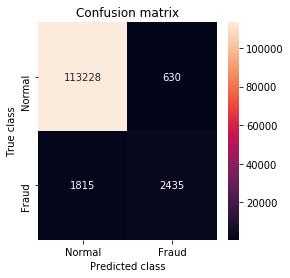

In [73]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (4,4))

sns.heatmap(df_cm, annot=True, fmt='g', xticklabels=LABELS, yticklabels=LABELS)

plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

mlflow.log_metric("Tnormal-Pnormal", cm[0][0])
mlflow.log_metric("Tnormal-Pfraud", cm[0][1])
mlflow.log_metric("Tfraud-Pnormal", cm[1][0])
mlflow.log_metric("Tfraud-Pfraud", cm[1][1])

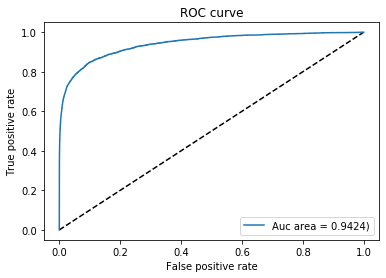

In [74]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Auc area = {:.4f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

mlflow.log_metric("auc", auc)


## Hyper tunning 

In [75]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
    
#     dropout_min  =  0
#     dropout_max  =  0.6
#     dropout_step =  0.1
    
#     for i in range(hp.Int('num_layers', 2, 10)):
#         model.add(Dense(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
#         model.add(Dropout( hp.Float('dropout'+ str(i),min_value=0,max_value=0.5,step=0.1) ) )
        
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     model.compile(
#         optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
#         loss="binary_crossentropy",
#         metrics=['acc']
#     )
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='acc',
#     max_trials=15,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='helloworld')

# tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [76]:
# tuner.search_space_summary()
# models = tuner.get_best_models(num_models=2)
# tuner.results_summary()
# print(tuner.get_best_hyperparameters()[0].values)

## 6. Saving model 

In [77]:
import joblib
import os 

current_dir = os.path.abspath('')
transformer_path = "data_transformer.joblib"

joblib.dump(transformer, transformer_path)

mlflow.keras.log_model(model, '')
mlflow.log_artifact(transformer_path, 'data')
mlflow.log_artifact(os.path.abspath('') + '/keras_model.ipynb')

os.remove(current_dir + '/' + transformer_path)

## 7. References 

Data analysis:
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
    
https://www.kaggle.com/tarunpaparaju/how-to-survive-the-shakeup-don-t-overfit
left on Ensembling


IDEAS:
    * check identity tabel
    * improve data preperation
    * categorical_features encoding using embedding
    * autoencoders
    * split data in a way that we only train on normal txs
    * Ensembling
    * oversampling/undersampling smoth
    * K-fold Cross-Validation 
     
    